# Data Profiling, Cleaning & EDA-Sierraleone
**Objective:** Profile, clean, and explore the solar dataset for Sierraleone so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [ ]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\sierraleone-bumbuna.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [ ]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

In [ ]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())

In [ ]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))

In [ ]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))

## Summary statistics and missing-value report

In [ ]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)



## Interpretation of Summary statistics and missing-value report

### 1. **General Overview**
- The dataset has 525,600 records — suggests 60 min × 24 hr × 365 days = 1 year of minute-level data.
- No missing numerical data (count = 525,600 for all measured variables).
- Comments column is empty (count = 0); can be dropped
- **Solar data (GHI, DNI, DHI)**: Negative GHI/DNI/DHI values are incorrect entries or sensor noise need correction
- **Module data (ModA, ModB)**: Consistent with irradiance
- **Temperature (Tamb, TModA, TModB)**: Physically valid
- **Humidity (RH)**: Reasonable; 9.9 %(min) low outlier may indicate a dry period or sensor drift.
- **Wind (WS, WSgust, WSstdev, WD, WDstdev)**: Wind readings are consistent; no clear data errors.
- **Pressure (BP)**: Normal atmospheric range at moderate altitude
- **Flags(Cleaning Flag & Precipitation)**: Sparse cleaning events → panels mostly uncleaned., no issues

## Univariate Analysis for Numeric Columns Only


Number of outliers per column:
GHI: 61
DNI: 15196
DHI: 7198
ModA: 71
ModB: 177
WS: 5407
WSgust: 4983
Cleaning: 485
Precipitation: 3789

Rows with flagged incorrect entries:
                     Negative_Radiation  Negative_Wind  Invalid_Cleaning  \
Timestamp                                                                  
2021-08-09 00:01:00                True          False             False   
2021-08-09 00:02:00                True          False             False   
2021-08-09 00:03:00                True          False             False   
2021-08-09 00:04:00                True          False             False   
2021-08-09 00:05:00                True          False             False   
...                                 ...            ...               ...   
2022-08-08 23:56:00                True          False             False   
2022-08-08 23:57:00                True          False             False   
2022-08-08 23:58:00                True          False            

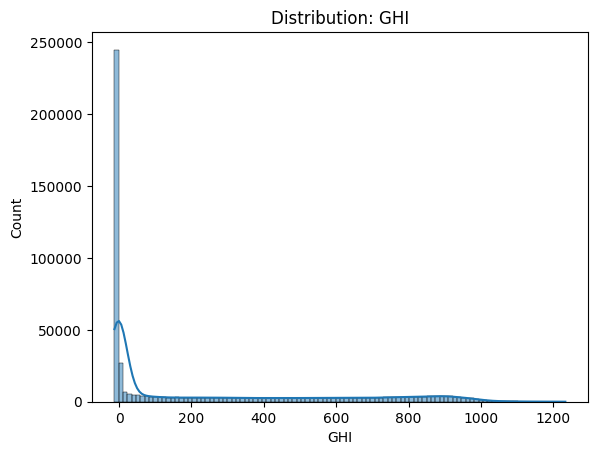

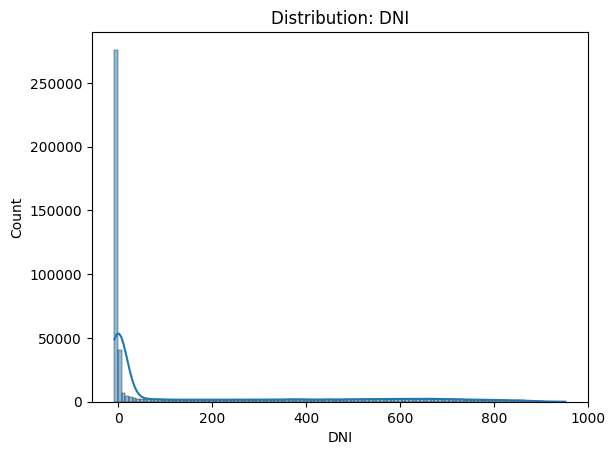

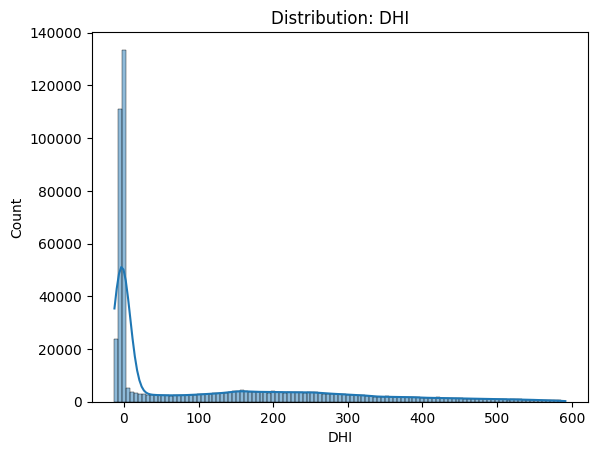

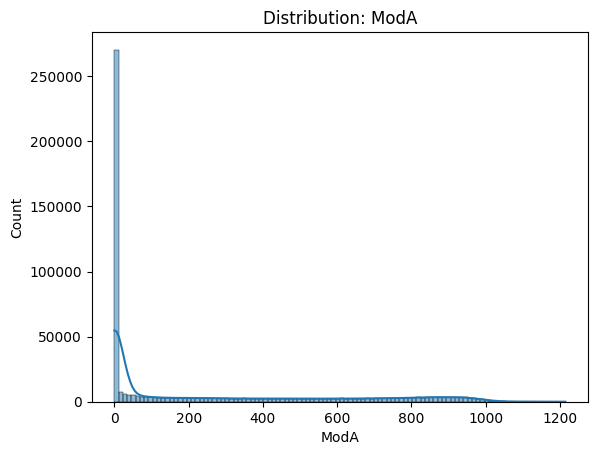

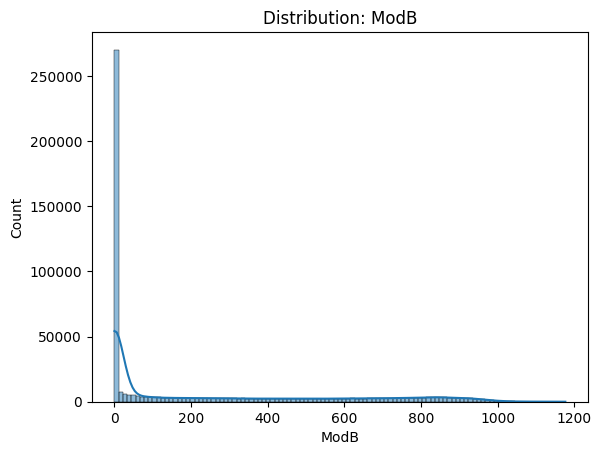

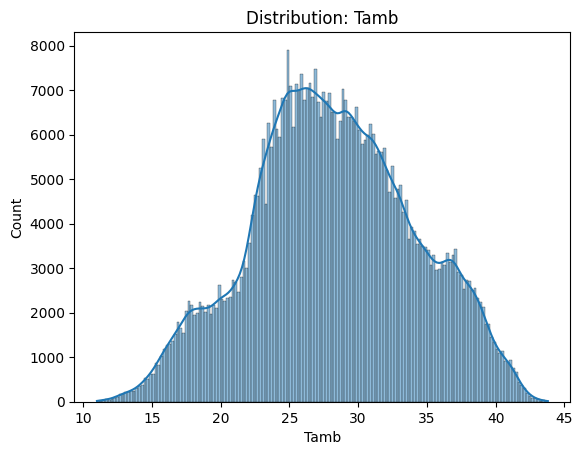

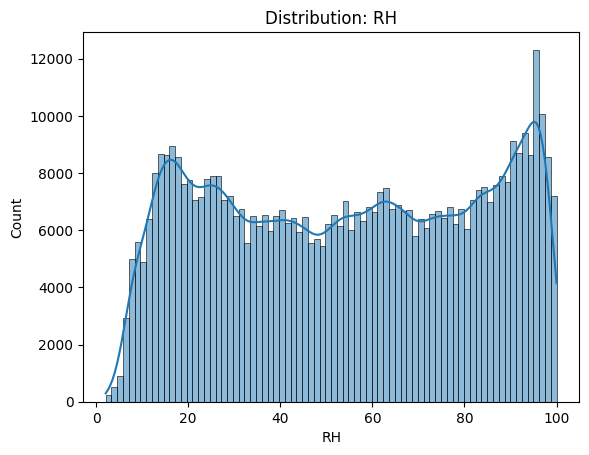

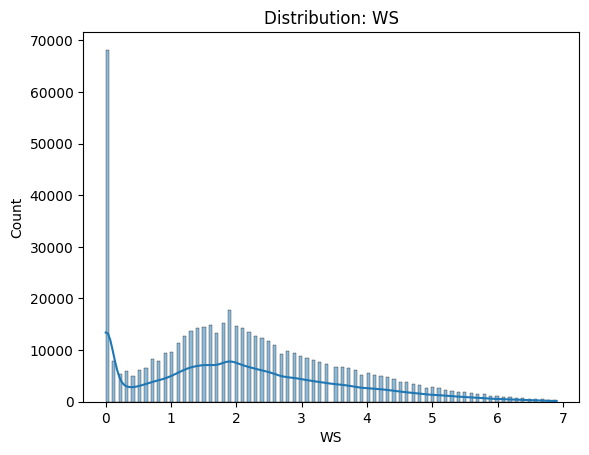

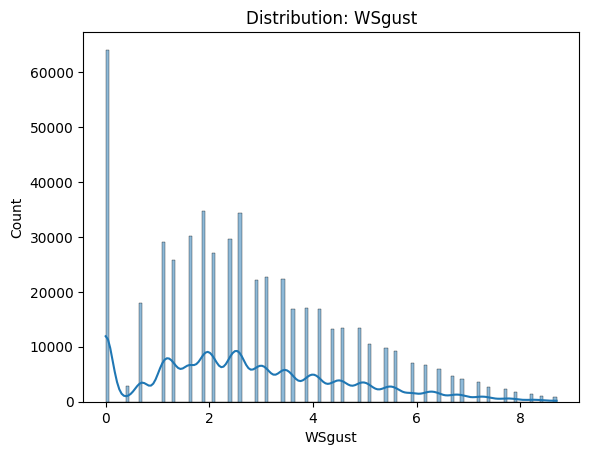

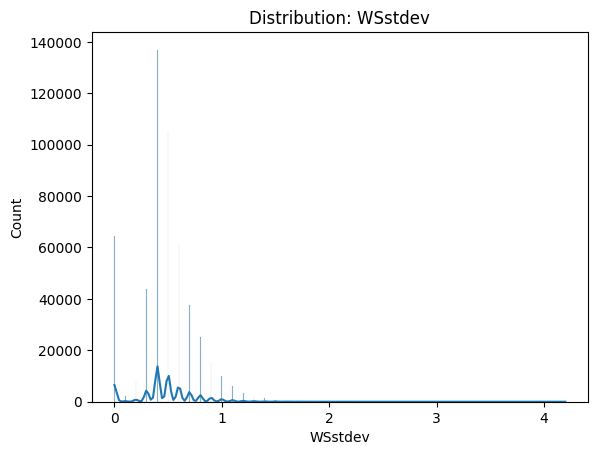

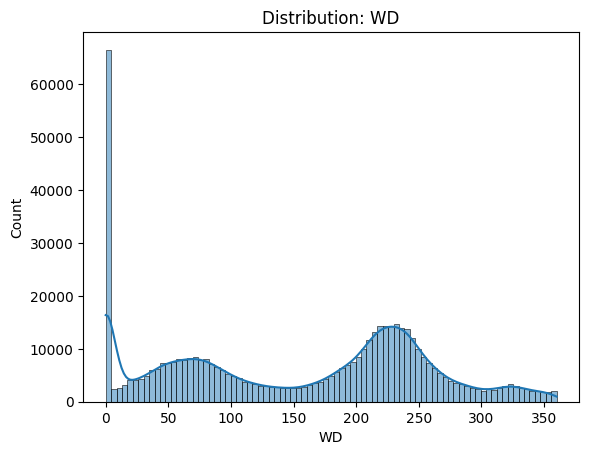

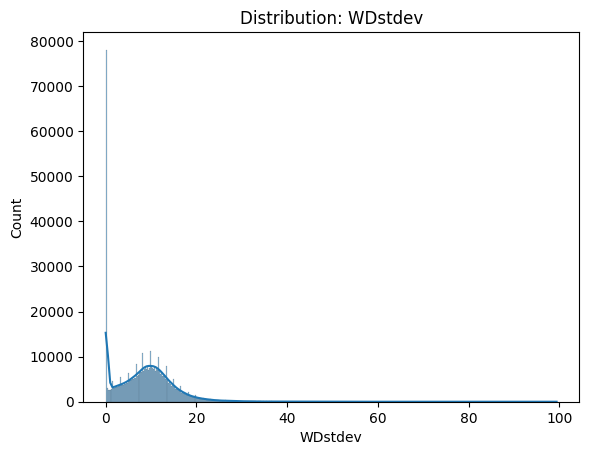

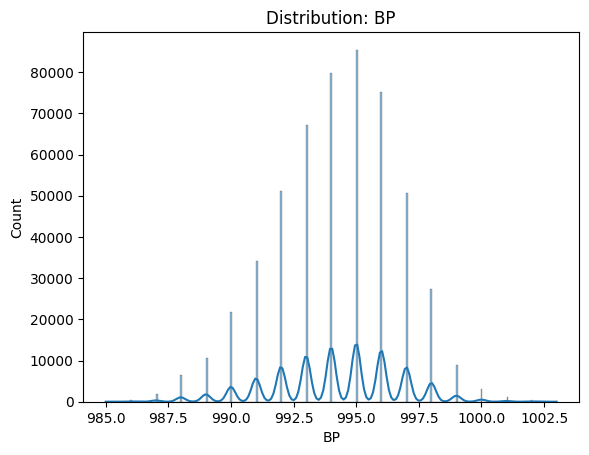

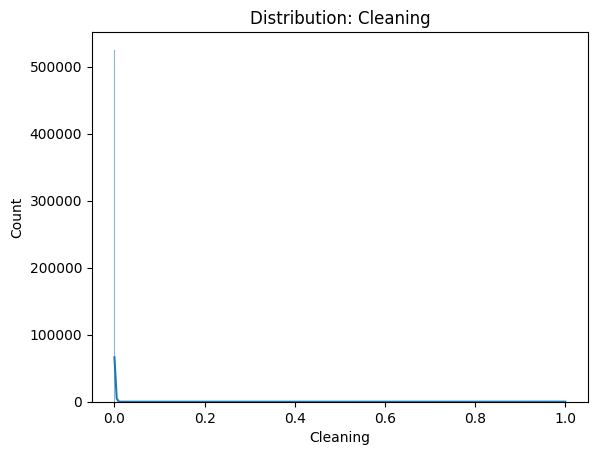

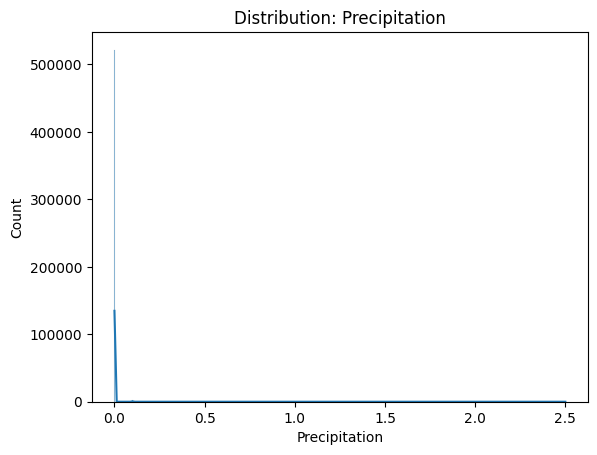

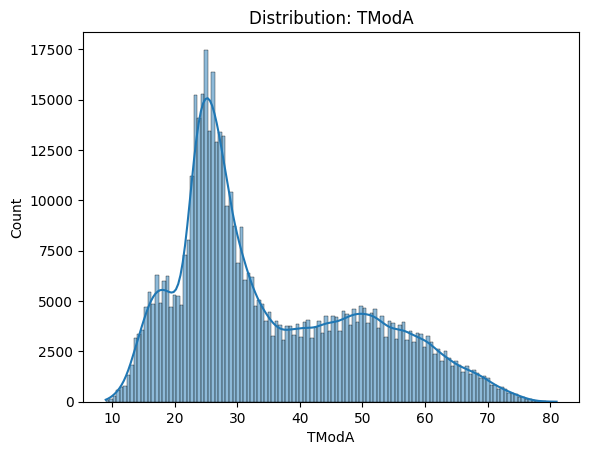

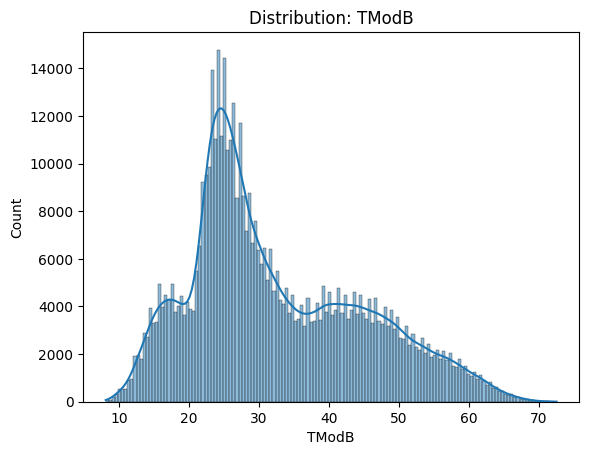

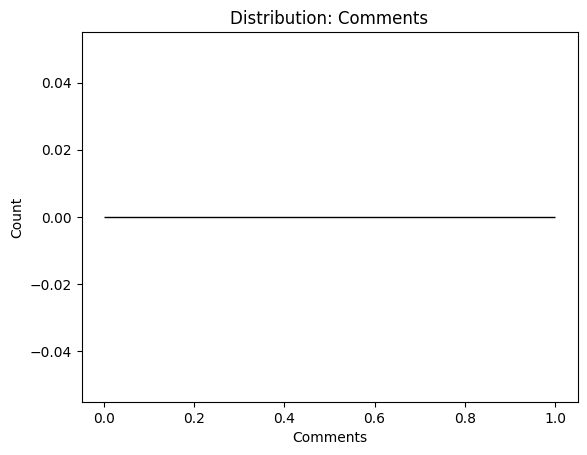

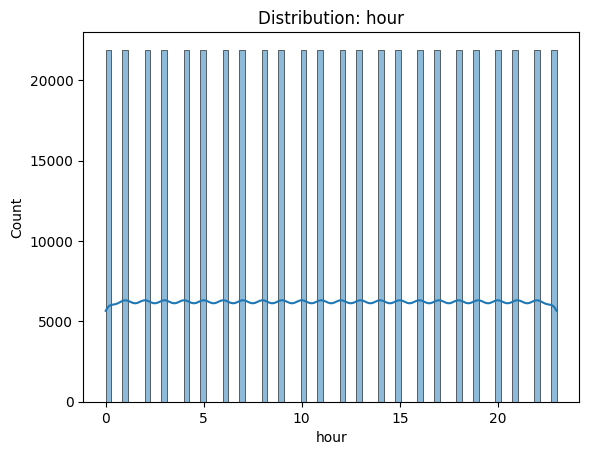

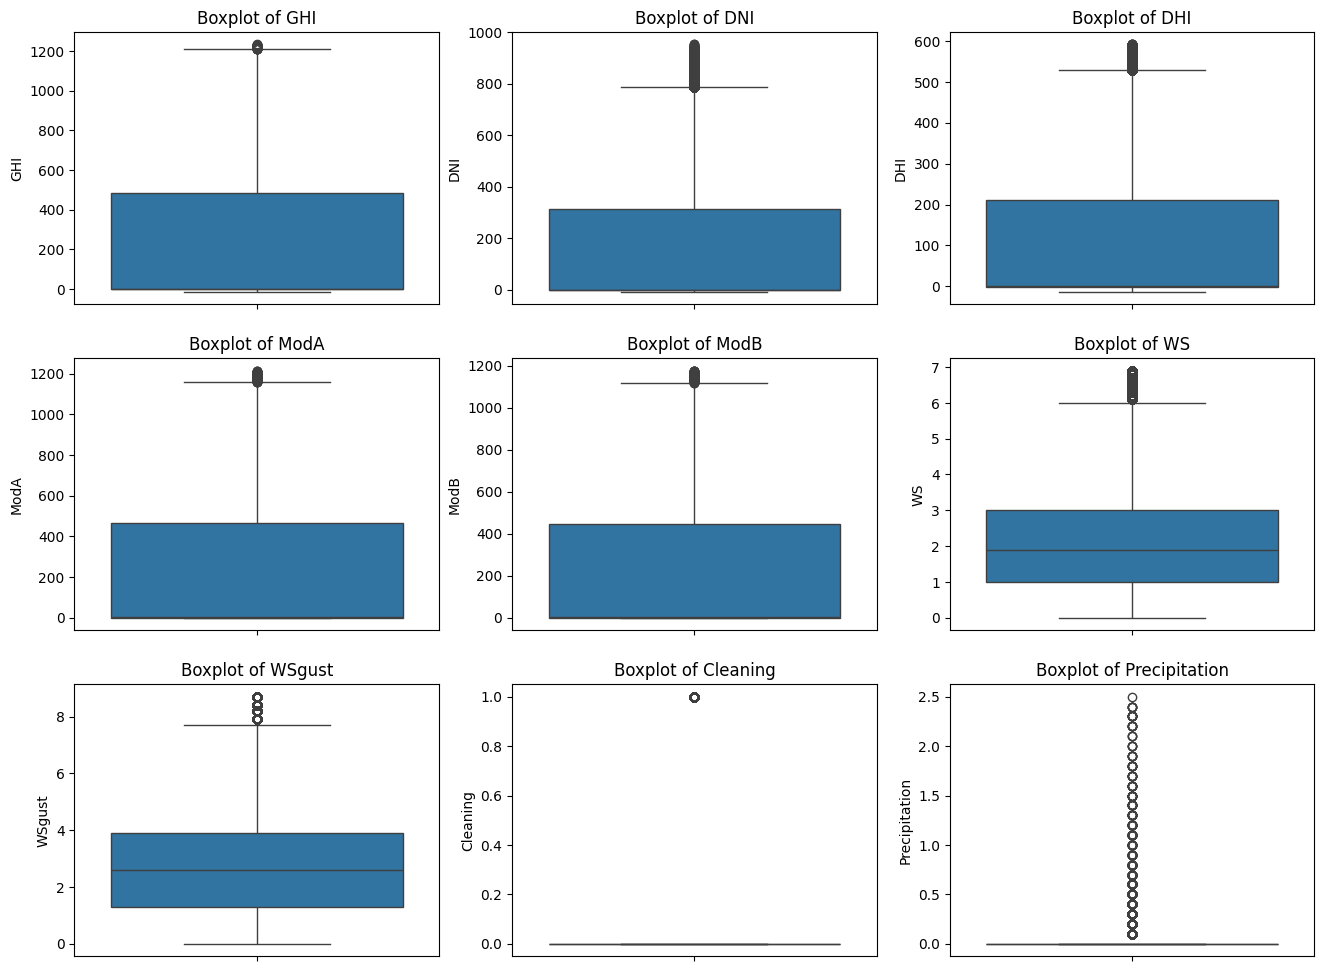

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to check
cols_radiation = ['GHI', 'DNI', 'DHI']
cols_sensor = ['ModA', 'ModB']
cols_wind = ['WS', 'WSgust']
cols_misc = ['Cleaning', 'Precipitation']

all_cols = cols_radiation + cols_sensor + cols_wind + cols_misc

#  Outlier detection using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

outlier_summary = {}
for col in all_cols:
    outliers = detect_outliers(df, col)
    outlier_summary[col] = len(outliers)
    
print("\nNumber of outliers per column:")
for col, count in outlier_summary.items():
    print(f"{col}: {count}")

# Flag potentially incorrect entries
# Negative radiation or wind, Cleaning not 0/1, negative precipitation
df_flags = pd.DataFrame(index=df.index)
df_flags['Negative_Radiation'] = (df[cols_radiation] < 0).any(axis=1)
df_flags['Negative_Wind'] = (df[cols_wind] < 0).any(axis=1)
df_flags['Invalid_Cleaning'] = ~df['Cleaning'].isin([0, 1])
df_flags['Negative_Precipitation'] = df['Precipitation'] < 0

print("\nRows with flagged incorrect entries:")
print(df_flags[df_flags.any(axis=1)])

# 4️⃣ Visualization
plt.figure(figsize=(16, 12))
for i, col in enumerate(all_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Histogram of {col}')
#plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 12))
for i, col in enumerate(all_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
#plt.tight_layout()
plt.show()


#### plot time series with highlighted outliers

### Computing Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; flag rows with |Z|>3.

In [33]:
import pandas as pd
from scipy.stats import zscore

# Columns to compute Z-scores for
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
df_z = df[key_columns].apply(zscore)

# Flag rows where |Z| > 3
outlier_flags = (df_z.abs() > 3)

# Extract rows with any outlier
df_outliers = df[outlier_flags.any(axis=1)].copy()

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_outliers['outlier_columns'] = outlier_flags.loc[df_outliers.index].apply(get_outlier_cols, axis=1)

# Summary: number of outlier rows
print("Number of rows with |Z|>3 in any column:", len(df_outliers))

# Inspect first few outlier rows
print(df_outliers.head())

# Keep only the columns that have outliers in each row
df_outlier_values = df_outliers.copy()
for col in key_columns:
    df_outlier_values[col] = df_outlier_values[col].where(outlier_flags[col])

# Optional: only show Timestamp + columns with outliers
df_outlier_values = df_outlier_values[['Timestamp'] + key_columns]

# Display or save
print(df_outlier_values.head(20))  # first 20 rows
# df_outlier_values.to_csv("data/benin_outliers.csv", index=False)

Number of rows with |Z|>3 in any column: 3708
                       GHI    DNI    DHI   ModA   ModB  Tamb    RH   WS  \
Timestamp                                                                 
2021-08-09 11:10:00  776.4  201.1  583.3  740.4  745.0  30.2  69.0  2.8   
2021-08-09 11:56:00  644.6   60.8  577.8  600.1  603.9  30.4  67.9  3.2   
2021-08-09 11:57:00  611.0   17.1  587.4  572.2  575.5  30.3  68.1  3.6   
2021-08-09 12:01:00  617.5   27.1  583.6  579.7  583.8  30.4  68.4  3.2   
2021-08-09 12:09:00  609.6   22.1  582.5  572.5  576.0  30.3  68.1  3.0   

                     WSgust  WSstdev     WD  WDstdev   BP  Cleaning  \
Timestamp                                                             
2021-08-09 11:10:00     3.6      0.6  171.8     20.1  999         0   
2021-08-09 11:56:00     4.4      0.9  211.8     15.1  999         0   
2021-08-09 11:57:00     4.1      0.5  218.5      6.6  999         0   
2021-08-09 12:01:00     4.1      0.7  215.9     13.7  999         0   
20

KeyError: "['Timestamp'] not in index"

## Cleaning the Data
### Dropping missing values in key columns

In [ ]:
# Key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Impute missing values with median safely
df_imputed = df.copy()
for col in key_columns:
    median_val = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].fillna(median_val)  # <-- assign back instead of inplace

# Check missing values
print("Missing values after median imputation:")
print(df_imputed[key_columns].isna().sum())

### Cleaning and Exporting cleaned DataFrame to data/benin_clean.csv 

In [ ]:
import os
import pandas as pd
# Ensure the 'data' folder exists inside your workspace
data_folder = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data"
os.makedirs(data_folder, exist_ok=True)
# Key columns for cleaning
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- Step 1: Impute missing values with median ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)

# --- Step 2: Compute Z-scores and flag outliers ---
df_z = df_cleaned[key_columns].apply(zscore)
outlier_flags = (df_z.abs() > 3)

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_cleaned['outlier_columns'] = outlier_flags.apply(get_outlier_cols, axis=1)

# replace outliers with median (you can skip if you just want to flag)
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned.loc[outlier_flags[col], col] = median_val

# --- Step 4: Summary ---
num_outlier_rows = (outlier_flags.any(axis=1)).sum()
print(f"Number of rows with outliers: {num_outlier_rows}")
print("Missing values after cleaning:")
print(df_cleaned[key_columns].isna().sum())

# Path to save the cleaned CSV
cleaned_csv_path = os.path.join(data_folder, "sierraleone_clean.csv")

# Save the cleaned DataFrame
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_csv_path}")

### rows were affected by missing values vs. outliers vs. cleaned values

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Key columns to check
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Total rows
total_rows = len(df)

# --- Missing values ---
missing_count_per_column = df[key_columns].isna().sum()
rows_with_missing = df[key_columns].isna().any(axis=1).sum()

# --- Z-score outliers ---
df_z = df[key_columns].apply(zscore)
outlier_flags = df_z.abs() > 3
rows_with_outliers = outlier_flags.any(axis=1).sum()

# --- After cleaning (median imputation and optional outlier replacement) ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)
    df_cleaned.loc[outlier_flags[col], col] = median_val

rows_cleaned = (df_cleaned[key_columns] != df[key_columns]).any(axis=1).sum()

# --- Summary report ---
report = pd.DataFrame({
    "Total Rows": [total_rows],
    "Rows with Missing Values": [rows_with_missing],
    "Rows with Outliers": [rows_with_outliers],
    "Rows Cleaned (Imputed or Replaced)": [rows_cleaned]
})

print(report)


## Time Series Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\benin_clean.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as index for better plotting
df.set_index('Timestamp', inplace=True)

# Columns to plot
columns_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

# --- Line chart ---
plt.figure(figsize=(15, 6))
for col in columns_to_plot:
    plt.plot(df.index, df[col], label=col)

plt.title("Solar and Temperature Data Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Ensure datetime index
# df = df.set_index('Timestamp')

# Select only numeric columns
df_numeric = df.select_dtypes(include='number')

# Hourly averages
df_hourly = df_numeric.resample('h').mean()

# Plot selected variables
cols_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

plt.figure(figsize=(15, 6))
for col in cols_to_plot:
    plt.plot(df_hourly.index, df_hourly[col], label=col)

plt.title("Hourly Average Solar and Temperature Data")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Observe patterns by month, trends throughout the day, or anomalies, such as peaks in solar irradiance or temperature fluctuations. 

In [ ]:
# Group by month and compute mean
monthly_mean = df_numeric.resample('M').mean()

plt.figure(figsize=(12,6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(monthly_mean.index.month, monthly_mean[col], label=col)

plt.title("Monthly Average Trends of Solar and Temperature Data")
plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.show()

df['hour'] = df.index.hour
hourly_pattern = df.groupby('hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12,6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(hourly_pattern.index, hourly_pattern[col], label=col)

plt.title("Average Diurnal Pattern (Hourly Averages Across All Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.show()

# detecting anomalies or peaks
plt.figure(figsize=(15,6))
plt.plot(df_hourly.index, df_hourly['GHI'], label='GHI', alpha=0.8)
plt.scatter(df_hourly.index[df_hourly['GHI'] > df_hourly['GHI'].quantile(0.99)], 
            df_hourly['GHI'][df_hourly['GHI'] > df_hourly['GHI'].quantile(0.99)],
            color='red', label='Potential Peaks', s=10)
plt.title("GHI with Potential Anomalies (Top 1%)")
plt.xlabel("Timestamp")
plt.ylabel("GHI")
plt.legend()
plt.tight_layout()
plt.show()


### Code to Group by Cleaning Flag

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Cleaning is numeric
df['Cleaning'] = df['Cleaning'].astype(int)

# Group by Cleaning flag
mod_means = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot comparison
mod_means.plot(kind='bar', figsize=(8,5), rot=0, color=['#4c72b0', '#55a868'])
plt.title("Average Module Output Before and After Cleaning")
plt.xlabel("Cleaning Flag (0 = Before, 1 = After)")
plt.ylabel("Average Module Output (W/m²)")
plt.legend(["ModA", "ModB"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: print numerical difference
print("Average ModA/ModB output before vs after cleaning:\n")
print(mod_means)
print("\nChange after cleaning (%):")
print((mod_means.loc[1] - mod_means.loc[0]) / mod_means.loc[0] * 100)


### Correlation & Relationship Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']

# Compute correlation matrix
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap — Irradiance and Module Temperatures")
plt.tight_layout()
plt.show()

# Define scatter plots
plt.figure(figsize=(15, 10))

# (a) WS vs GHI
plt.subplot(2, 3, 1)
plt.scatter(df['WS'], df['GHI'], alpha=0.4)
plt.title("WS vs GHI")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("GHI (W/m²)")

# (b) WSgust vs GHI
plt.subplot(2, 3, 2)
plt.scatter(df['WSgust'], df['GHI'], alpha=0.4, color='orange')
plt.title("WSgust vs GHI")
plt.xlabel("Wind Gust (m/s)")
plt.ylabel("GHI (W/m²)")

# (c) WD vs GHI
plt.subplot(2, 3, 3)
plt.scatter(df['WD'], df['GHI'], alpha=0.4, color='green')
plt.title("WD vs GHI")
plt.xlabel("Wind Direction (°)")
plt.ylabel("GHI (W/m²)")

# (d) RH vs Tamb
plt.subplot(2, 3, 4)
plt.scatter(df['RH'], df['Tamb'], alpha=0.4, color='red')
plt.title("RH vs Tamb")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")

# (e) RH vs GHI
plt.subplot(2, 3, 5)
plt.scatter(df['RH'], df['GHI'], alpha=0.4, color='purple')
plt.title("RH vs GHI")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()


### visualizing wind behavior and value distributions

In [ ]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Remove invalid data
df_valid = df.dropna(subset=['WS', 'WD'])

# Create wind rose
ax = WindroseAxes.from_ax()
ax.bar(df_valid['WD'], df_valid['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="Wind speed (m/s)", bbox_to_anchor=(1.1, 0))
plt.title("Wind Rose: Wind Speed vs Direction", fontsize=14)
plt.show()


plt.figure(figsize=(12, 5))

# GHI Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['GHI'].dropna(), bins=40, kde=True, color='gold')
plt.title("Distribution of Global Horizontal Irradiance (GHI)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequency")

# WS Histogram
plt.subplot(1, 2, 2)
sns.histplot(df['WS'].dropna(), bins=40, kde=True, color='skyblue')
plt.title("Distribution of Wind Speed (WS)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Scatter Plots — RH vs Tamb, RH vs GHI

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# RH vs Temperature
plt.subplot(1, 2, 1)
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.3, color='coral')
sns.regplot(x='RH', y='Tamb', data=df, scatter=False, color='black', line_kws={'lw': 2})
plt.title("RH vs Ambient Temperature (Tamb)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")

# RH vs GHI
plt.subplot(1, 2, 2)
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.3, color='skyblue')
sns.regplot(x='RH', y='GHI', data=df, scatter=False, color='black', line_kws={'lw': 2})
plt.title("RH vs Global Horizontal Irradiance (GHI)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()


### GHI vs. Tamb with bubble size = RH or BP.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Scatter with bubble size = RH
plt.scatter(
    df['Tamb'], df['GHI'],
    s=df['RH'] * 2,          # scale bubble size
    c=df['RH'],              # color by RH
    cmap='coolwarm', alpha=0.6, edgecolors='k'
)

plt.title('GHI vs. Tamb with Bubble Size = RH', fontsize=14)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance (GHI, W/m²)')
plt.colorbar(label='Relative Humidity (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))

plt.scatter(
    df['Tamb'], df['GHI'],
    s=(df['BP'] - df['BP'].min()) / 2,  # normalize pressure to control bubble size
    c=df['BP'], cmap='viridis', alpha=0.6, edgecolors='k'
)

plt.title('GHI vs. Tamb with Bubble Size = BP', fontsize=14)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance (GHI, W/m²)')
plt.colorbar(label='Barometric Pressure (hPa)')
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# RH
axes[0].scatter(df['Tamb'], df['GHI'], s=df['RH']*2, c=df['RH'], cmap='coolwarm', alpha=0.6, edgecolors='k')
axes[0].set_title('Bubble Size = RH')
axes[0].set_xlabel('Tamb (°C)')
axes[0].set_ylabel('GHI (W/m²)')

# BP
axes[1].scatter(df['Tamb'], df['GHI'], s=(df['BP'] - df['BP'].min())/2, c=df['BP'], cmap='viridis', alpha=0.6, edgecolors='k')
axes[1].set_title('Bubble Size = BP')
axes[1].set_xlabel('Tamb (°C)')
axes[1].set_ylabel('GHI (W/m²)')

plt.tight_layout()
plt.show()
